# Gate calibration with RL with the Quantum Orchestration Platform

This notebook is the template workflow enabling you to run gate calibration leveraging all the low-level capabilities of the QOP for maximum efficiency.

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, Gate
from typing import List
from gymnasium.spaces import Box
from gymnasium.wrappers import RescaleAction, ClipAction
from rl_qoc.qua import QMEnvironment, QMConfig, CustomQMPPO
from iqcc_calibration_tools.quam_config.components import Quam, Transmon
from qiskit_qm_provider import FluxTunableTransmonBackend, QMInstructionProperties, InputType, IQCCProvider
from qiskit_qm_provider.backend import add_basic_macros_to_machine
from rl_qoc.agent.ppo_config import (
    WandBConfig,
    PPOConfig,
    TrainingConfig,
    TrainFunctionSettings,
    TotalUpdates,
)
from rl_qoc import (
    RescaleAndClipAction,
    ChannelReward,
    StateReward,
    CAFEReward,
    ExecutionConfig,
    QEnvConfig,
    BenchmarkConfig,
    GateTarget,
    StateTarget,
)

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/helpers/__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")


2025-11-27 21:51:01,161 - qm - INFO     - Starting session: 35f19b6d-7016-4ade-9cbe-2d868367e9c3
2025-11-27 21:51:01 INFO Starting session: 35f19b6d-7016-4ade-9cbe-2d868367e9c3


## Accessing the device through the Qiskit QM Provider

Here, we fetch the latest calibration data from one of the IQCC available devices. For now, the two available ones are Gilboa ("gilboa") and Arbel ("arbel").

In [2]:
name = "arbel"
provider = IQCCProvider()
machine = provider.get_machine(name)
add_basic_macros_to_machine(machine)
backend = provider.get_backend(machine)
backend.set_options(timeout=100)
print(backend.target)

Target: Qiskit Backend for Quantum Abstract Machine (Quam) of arbel
Number of qubits: 18
Instructions:
	x
		(0,):
			Duration: 4.8e-08 sec.
		(1,):
			Duration: 4.8e-08 sec.
		(2,):
			Duration: 4.8e-08 sec.
		(3,):
			Duration: 4.8e-08 sec.
		(4,):
			Duration: 4.8e-08 sec.
		(5,):
			Duration: 4.8e-08 sec.
		(6,):
			Duration: 4.8e-08 sec.
		(7,):
			Duration: 4.8e-08 sec.
		(8,):
			Duration: 4.8e-08 sec.
		(9,):
			Duration: 4.8e-08 sec.
		(10,):
			Duration: 4.8e-08 sec.
		(11,):
			Duration: 4.8e-08 sec.
		(12,):
			Duration: 4.8e-08 sec.
		(13,):
			Duration: 4.8e-08 sec.
		(14,):
			Duration: 4.8e-08 sec.
		(15,):
			Duration: 5.2e-08 sec.
		(16,):
			Duration: 4.8e-08 sec.
		(17,):
			Duration: 4.8e-08 sec.
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
		(2,):
			Duration: 0 sec.
			Error Rate: 0
		(3,):
			Duration: 0 sec.
			Error Rate: 0
		(4,):
			Duration: 0 sec.
			Error Rate: 0
		(5,):
			Duration: 0 sec.
			Error Rate: 0


/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/flux_tunable_transmon_backend.py:56: UserWarning: qiskit.pulse is not available, channel mapping will not be set.
  warnings.warn("qiskit.pulse is not available, channel mapping will not be set.")


## Creating a Qiskit Backend interface from Quam.

We have created a powerful Qiskit to QUA compiler that can enable the compilation (and execution) of almost all Qiskit QuantumCircuits, as long as they are transpiled against the backend object created from the Quam that we define below.

In [3]:
print(backend.options)

Options(shots=1024, compiler_options=None, simulate=None, memory=False, skip_reset=False, meas_level=<MeasLevel.CLASSIFIED: 2>, meas_return=<MeasReturnType.AVERAGE: 'avg'>, timeout=100)


In [4]:
print("Available qubits: ", backend.qubit_dict)
print("Available qubit pairs: ", backend.qubit_pair_dict)

Available qubits:  {'qA1': 0, 'qA2': 1, 'qA3': 2, 'qA4': 3, 'qA6': 4, 'qB1': 5, 'qB2': 6, 'qB3': 7, 'qB4': 8, 'qB5': 9, 'qC1': 10, 'qC2': 11, 'qC4': 12, 'qD1': 13, 'qD2': 14, 'qD3': 15, 'qD4': 16, 'qD5': 17}
Available qubit pairs:  {'qC2-qC4': (11, 12), 'qD1-qD2': (14, 13), 'qD1-qD3': (15, 13), 'qB1-qB3': (7, 5)}


In [5]:
backend.name

'arbel'

In [6]:
using_vpn = True
if using_vpn:
    machine.network["cloud"] = False
    machine.network["port"] = 9510
    
else:
    backend.qmm = iqcc

## Create a custom gate to edit

We add at the Qiskit level the custom gate we want to calibrate, and we then specify the QUA macro in charge of 
implementing the parametrized pulse representation of this template parametrized gate.

The way we specify such gate is by implementing a function (think about a Pennylane qnode), that modifies an input QuantumCircuit, and adds a custom Gate of your choice that is parametrized in a certain fashion.
The choice of the parametrization is defined by the action space specification (see below), and the shape of the QUA macro you decide to insert as a physical implementation of your gate. 
For now, parametrization is constrained to parameters that can be used to update the pulses in real-time, e.g. amplitude, phase, frequency, duration. For more advanced composite pulses, we can also think about baking some precomposite pulses, that could then be passed as keyword arguments to the parametrized circuit function.

In [7]:
from rl_qoc.helpers import add_custom_gate

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: List[Parameter], q_reg: QuantumRegister, **kwargs
):

    physical_qubits: List[int] = kwargs["physical_qubits"]
    backend: FluxTunableTransmonBackend = kwargs["backend"]

    # TODO: Enter your custom parametric QUA macro here
    def qua_macro(amp):
        qubit: Transmon = backend.get_qubit(physical_qubits[0])
        qubit.xy.play("x180", amplitude_scale=amp)

    # Create a custom gate with the QUA macro
    custom_x = Gate("x_cal", 1, params)
    x_duration = backend.target["x"][(physical_qubits[0],)].duration
    instruction_prop = QMInstructionProperties(duration=x_duration, 
                                               qua_pulse_macro=qua_macro)
    qc = add_custom_gate(
        qc,
        custom_x,
        q_reg,
        params,
        physical_qubits,
        backend,
        instruction_prop
    )
    return qc

## Create Environment configuration

1. Create target instance: Specify which gate you want and on which qubit it should be applied
2. Choose which reward scheme you want. You can choose among three methods that are carefully implemented within the QOP: Direct Channel/State Fidelity Estimation (DFE), and Context-Aware Fidelity Estimation (CAFE)

In [8]:
physical_qubits = (0,)
target_gate = "x"
target_state = "1"
# We show the two possible targets:
# 1. A gate target, i.e. a gate that we want to calibrate
gate_target = GateTarget(physical_qubits=physical_qubits, gate=target_gate)
# 2. A state target, i.e. a state that we want to reach
state_target = StateTarget(state=target_state, physical_qubits=physical_qubits)
# Choose the target
target = gate_target
# Initialize the reward scheme to be used in the environment
reward = ChannelReward()

In [9]:
"""
It is possible to define custom reward methods, by inheriting from the Reward class. 
The two main methods to implement are:
- get_reward_data: this method is called to generate the necessary data to pass to the OPX to compute the reward (e.g., observables, input states)
- rl_qoc_training_qua_prog: this method is called to generate the QUA program that will be executed on the device to compute the reward.
- qm_step: this method is called to compute the reward for a given epoch.
"""
from rl_qoc.qua.pi_pulse_reward import PiPulseReward
# reward = PiPulseReward()




3. Decide which action space to create
4. Decide how the parameters should be passed to the QOP (Choose between Input Stream, DGX Quantum, IO variables)
5. To fix the QUA program duration, we also can pass to the configuration the number of training updates expected (it should be the same variable used when declaring the agent).
6. Set up training hyperparameters on the environment side

In [10]:
# Action space specification
param_bounds = [(0., 2.0)]  # Can be any number of bounds


# Environment execution parameters
seed = 98  # Master seed to make training reproducible
batch_size = 8*4  # Number of actions to evaluate per policy evaluation
n_shots = 10 # Minimum number of shots per fiducial evaluation
pauli_sampling = 10  # Number of fiducials to compute for fidelity estimation (DFE only)
n_reps = [1, 3, 5]  # Number of repetitions of the cycle circuit
num_updates = TotalUpdates(20)

input_type = InputType.INPUT_STREAM
test_mode = True


def create_action_space(param_bounds):
    param_bounds = np.array(param_bounds, dtype=np.float32)
    lower_bound, upper_bound = param_bounds.T
    return Box(low=lower_bound, high=upper_bound, shape=(len(param_bounds),), dtype=np.float32)


action_space = create_action_space(param_bounds)

backend_config = QMConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    input_type=input_type,
    verbosity=2,
    parametrized_circuit_kwargs={"physical_qubits": physical_qubits, "backend": backend},
    num_updates=num_updates.total_updates,
    timeout=40,
    test_mode=test_mode,
)
execution_config = ExecutionConfig(
    batch_size=batch_size,
    sampling_paulis=pauli_sampling,
    n_shots=n_shots,
    n_reps=n_reps,
    seed=seed,
)
q_env_config = QEnvConfig(
    target=target,
    backend_config=backend_config,
    action_space=action_space,
    execution_config=execution_config,
    reward=reward,
    benchmark_config=BenchmarkConfig(0),
)  # No benchmark for now

q_env = QMEnvironment(training_config=q_env_config)
rescaled_env = RescaleAndClipAction(q_env, np.float32(-1.0), np.float32(1.0))
print("Env config: ", q_env.config.as_dict())

Env config:  {'target': {'gate': 'x', 'physical_qubits': [0]}, 'backend_config': {'input_type': 'INPUT_STREAM', 'verbosity': 2, 'num_updates': 20, 'path_to_python_wrapper': None}, 'action_space': {'low': [0.0], 'high': [2.0]}, 'execution_config': {'batch_size': 32, 'sampling_paulis': 10, 'n_shots': 10, 'n_reps': [1, 3, 5], 'c_factor': 1.0, 'seed': 98}, 'reward_config': 'channel', 'benchmark_config': {'benchmark_cycle': 0, 'check_on_exp': False}, 'metadata': {}}


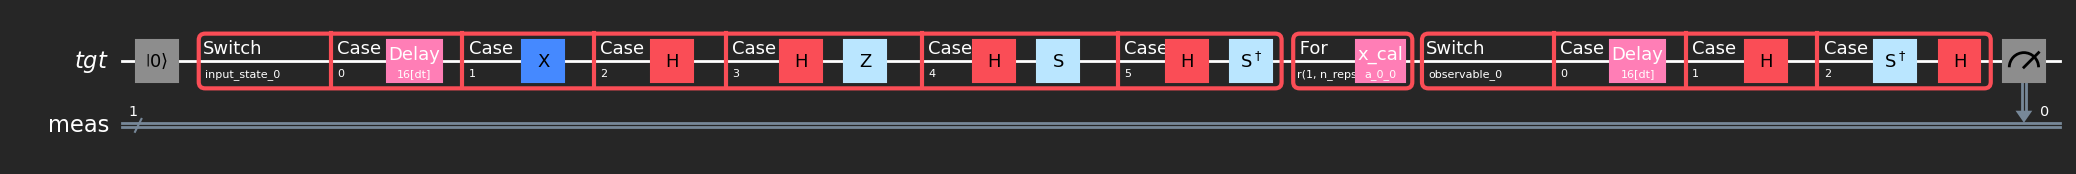

In [11]:
q_env.real_time_circuit.draw("mpl", style="iqp-dark", fold=30)

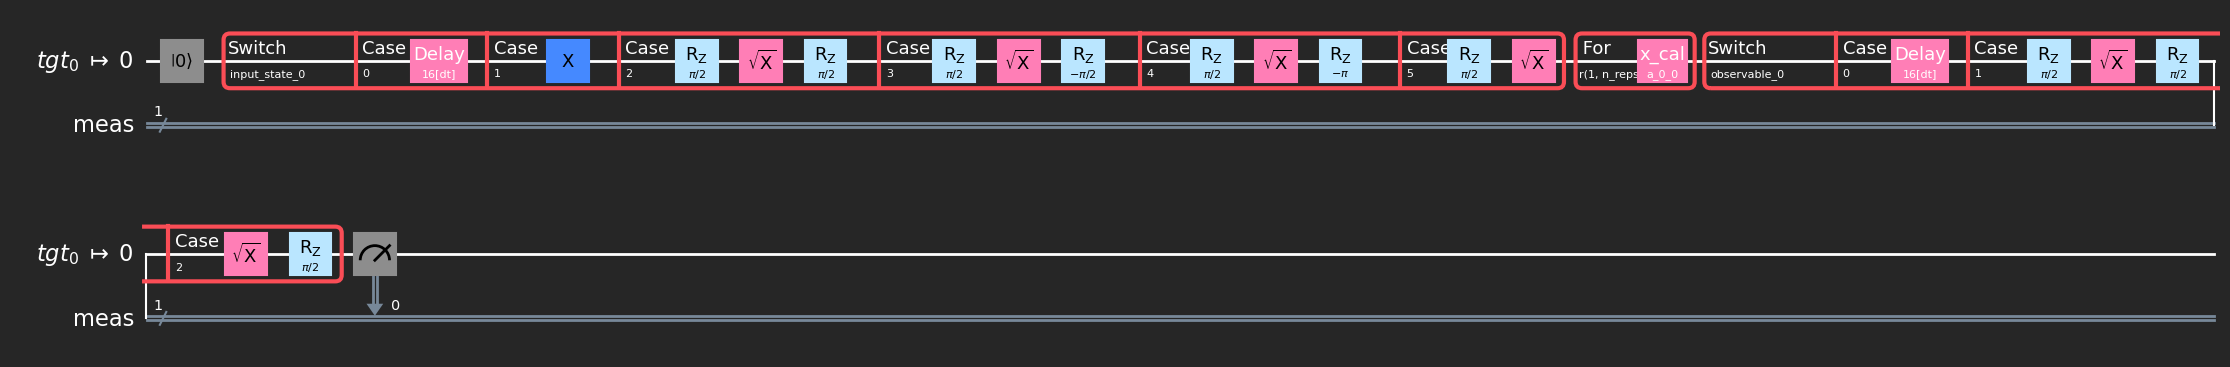

In [12]:
q_env.real_time_transpiled_circuit.draw("mpl", fold=32, style="iqp-dark")

In [13]:
"""Test the ForLoopOp with a range"""
from qiskit import ClassicalRegister
import numpy
pi = numpy.pi
qr = QuantumRegister(4, "q")
cr = ClassicalRegister(3, "cr")
circuit = QuantumCircuit(qr, cr)

a = Parameter("a")
circuit.h(0)
circuit.measure(0, 2)
with circuit.for_loop(range(10, 20), loop_parameter=a):
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.rx(pi / a, 1)
    circuit.measure(0, 0)
    with circuit.if_test((cr[2], 1)):
        circuit.z(0)

fname = "for_loop_range.png"


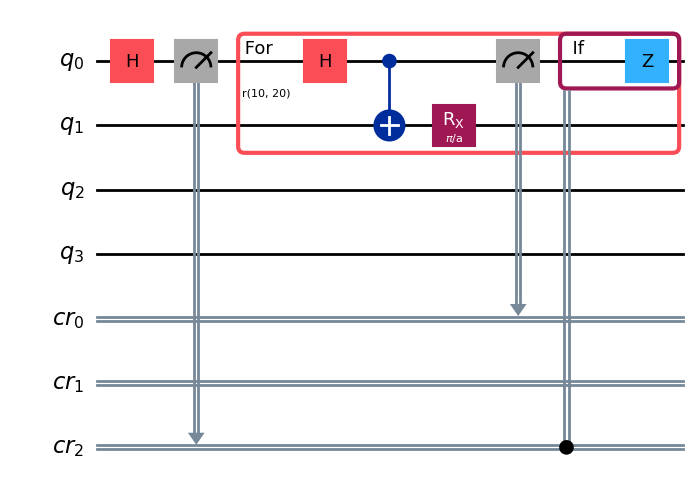

In [16]:
circuit.draw('mpl', cregbundle=False, filename="for_loop_range.png")

In [15]:
# Print the OpenQASM3 program
print(backend.oq3_exporter.dumps(q_env.real_time_transpiled_circuit))

OPENQASM 3.0;
input float[64] a_0_0;
input uint[32] n_reps;
input uint[32] input_state_0;
input uint[32] observable_0;
bit[1] meas;
int switch_dummy;
int switch_dummy_0;
reset $0;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
    delay[16dt] $0;
  }
  case 1 {
    x $0;
  }
  case 2 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
  }
  case 3 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(-1.570796326794897) $0;
  }
  case 4 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(-3.141592653589793) $0;
  }
  case 5 {
    rz(1.5707963267948966) $0;
    sx $0;
  }
}
for uint[32] _ in [1:1:n_reps] {
  x_cal(a_0_0) $0;
}
switch_dummy_0 = observable_0;
switch (switch_dummy_0) {
  case 0 {
    delay[16dt] $0;
  }
  case 1 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
  }
  case 2 {
    sx $0;
    rz(1.5707963267948966) $0;
  }
}
meas[0] = measure $0;



In [25]:
from qm import generate_qua_script
# Print the QUA program
print(generate_qua_script(q_env.rl_qoc_training_qua_prog(num_updates.total_updates)))


# Single QUA script generated at 2025-09-12 16:01:11.404957
# QUA library version: 1.2.2

from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_input_state_0 = declare_input_stream(int, 'input_state_0', value=0)
    input_stream_observable_0 = declare_input_stream(int, 'observable_0', value=0)
    input_stream_pauli_shots = declare_input_stream(int, 'pauli_shots', value=10)
    input_stream_max_input_state = declare_input_stream(int, 'max_input_state', value=1)
    input_stream_max_observables = declare_input_stream(int, 'max_observables', value=0)
    v1 = declare(fixed, value=0.0)
    input_stream_mu = declare_input_stream(fixed, 'mu', value=[0.0])
    input_stream_sigma = declare_input_stream(fixed, 'sigma', value=[1.0])
    a1 = declare(int, value=[0, 0])
    v2 = declare(int, )
    v3 = declare(int, )
    v4 = declare(int, )
    v5 = declare(int, )
    v6 = declare(int, )
    v7 = declare(int, )
    v8 = declare(int, )
    a2 = decl

In [16]:
reward.get_reward_data(
    q_env.circuit, np.zeros((q_env.batch_size, q_env.n_actions)), q_env.target, q_env.config
)

ChannelRewardDataList([ChannelRewardData(pub=EstimatorPub(<(32,)>), input_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x344cf07d0>, observables=SparsePauliOp(['X'],
              coeffs=[-1.+0.j]), n_reps=1, causal_cone_qubits_indices=[0], input_pauli=Pauli('X'), input_indices=(3,), observables_indices=[(1,)]), ChannelRewardData(pub=EstimatorPub(<(32,)>), input_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x344633cd0>, observables=SparsePauliOp(['X'],
              coeffs=[1.+0.j]), n_reps=1, causal_cone_qubits_indices=[0], input_pauli=Pauli('X'), input_indices=(2,), observables_indices=[(1,)]), ChannelRewardData(pub=EstimatorPub(<(32,)>), input_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x34423b310>, observables=SparsePauliOp(['Y'],
              coeffs=[1.5-0.j]), n_reps=1, causal_cone_qubits_indices=[0], input_pauli=Pauli('Y'), input_indices=(5,), observables_indices=[(2,)]), ChannelRewardData(pub=EstimatorPub(<(32,)>), inp

# Defining the Agent and launching training

To push efficiency, we have introduced a custom version of the PPO algorithm whose particularity is that the sampling of the actions is in fact replicating a sampling mechanism done in real-time within the OPX. This way, we can through seed sharing share the actions between the two entities without having to introduce any communication latency to perform training.

In [29]:
ppo_config = PPOConfig.from_yaml("agent_config.yaml")
ppo_agent = CustomQMPPO(ppo_config, rescaled_env)
ppo_training = TrainingConfig(num_updates)
ppo_settings = TrainFunctionSettings(plot_real_time=True, print_debug=True, num_prints=10)

In [30]:
running_jobs = backend.qmm.get_jobs(status="Running")
print(running_jobs)

[]


In [31]:
backend.close_all_qms()

In [32]:
running_jobs = backend.qmm.get_jobs(status="Running")
print(running_jobs)
if not running_jobs:
    q_env.clear_history()
    job = q_env.start_program()
    results = ppo_agent.train(ppo_training, ppo_settings)

[]


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/quam/components/channels.py:636: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(


QMConnectionError: Encountered connection error from QOP: details: An internal error occurred., status: Status.INTERNAL

In [22]:
results

{'avg_reward': [0.380625,
  0.400625,
  0.4190625,
  0.39999999999999997,
  0.40156249999999993],
 'fidelity_history': [],
 'hardware_runtime': [0.029133199999999998,
  0.029133199999999998,
  0.029133199999999998,
  0.029133199999999998,
  0.029133199999999998],
 'total_shots': [100, 100, 100, 100, 100],
 'total_updates': [],
 'clipped_mean_action_0': [0.09371373802423477,
  0.11522991210222244,
  -0.01963583566248417,
  0.2777049243450165,
  0.1211027204990387],
 'mean_action_0': [0.04206724464893341,
  0.05287938937544823,
  -0.014892343431711197,
  0.1345251202583313,
  0.05583054944872856],
 'std_action_0': [0.502479076385498,
  0.49933379888534546,
  0.6567396521568298,
  0.7888306975364685,
  0.8054054379463196],
 'mean_action': [0.05583054944872856],
 'std_action': [0.8054054379463196],
 'clipped_mean_action': [0.1211027204990387]}

In [31]:
job.halt()

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_13534/2760244435.py:1: DeprecationWarning: job.halt is deprecated since "1.2.0" and will be removed in "1.4.0". This method was renamed to `job.cancel`.
  job.halt()


True

In [ ]:
# Amplitude sweeping (Rabi Oscillation)
q_env.std_action = np.array([0.01], dtype=np.float32)
reward = []
q_env.step_tracker = 0
q_env.clear_history()
q_env.start_program()
for action in np.linspace(-1.0, 1.0, 20):
    q_env.mean_action = np.array([action], dtype=np.float32)
    print(q_env.step(np.array([action], dtype=np.float32))[1])
    reward.append(q_env.reward_history[-1])
    q_env.step_tracker += 1

/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/quam/quam/components/channels.py:647: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(


2025-07-24 17:21:22,629 - qm - INFO     - Clearing queue
2025-07-24 17:21:22 INFO Clearing queue
2025-07-24 17:21:24,040 - qm - INFO     - Adding program to queue.
2025-07-24 17:21:24 INFO Adding program to queue.
Pushing value [-1.9800000190734863] to mu through input stream.
Pushing value [0.009999999776482582] to sigma through input stream.
Just pushed policy parameters to OPX: [-1.9800000190734863] [0.009999999776482582]
Rescaled mean: [-1.98000002]
Fetching index: 0, finishing index: 1
Fetching size: 1
Step indices: {0: (0, 1)}
Total data points: 1
Pushing value 0 to input_state_0 through input stream.
Pushing value 1 to max_observables through input stream.
Pushing value 100 to pauli_shots through input stream.
Pushing value 0 to observable_0 through input stream.
Fetching value from reward with input type None
Fetched value: [[[64 36]
  [62 38]
  [71 29]
  [57 43]
  [58 42]
  [54 46]
  [64 36]
  [56 44]
  [65 35]
  [62 38]
  [60 40]
  [64 36]
  [63 37]
  [57 43]
  [63 37]
  [67 

QopResponseError: Error from QOP, details:
Job 11020d50-05d5-458a-b88d-b5709e544b07 was not found.

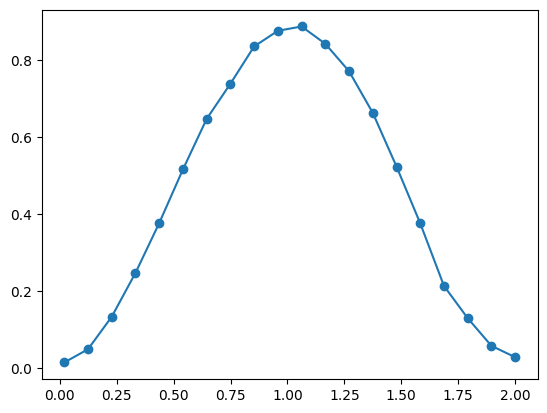

In [32]:
import matplotlib.pyplot as plt
plt.plot(rescaled_env.action(np.linspace(-1.0, 1.0, 20)), np.mean(q_env.reward_history, axis=-1), marker="o")

In [31]:
from qiskit.quantum_info import SparsePauliOp
SparsePauliOp.from_operator(target.dm.to_operator())

SparsePauliOp(['I', 'Z'],
              coeffs=[ 0.5+0.j, -0.5+0.j])

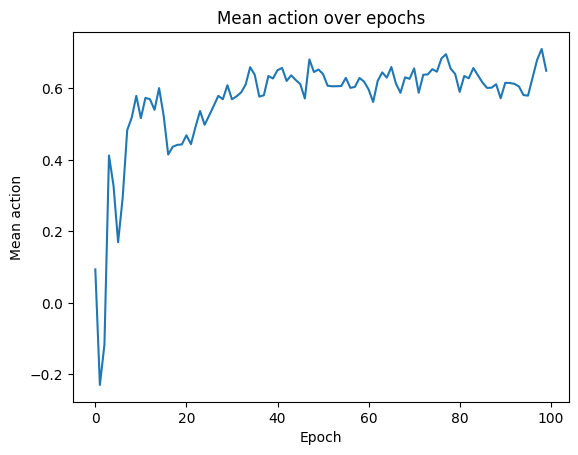

In [32]:
import matplotlib.pyplot as plt
plt.plot(ppo_agent.training_results["clipped_mean_action_0"])
plt.xlabel("Epoch")
plt.ylabel("Mean action")
plt.title("Mean action over epochs")
plt.show()

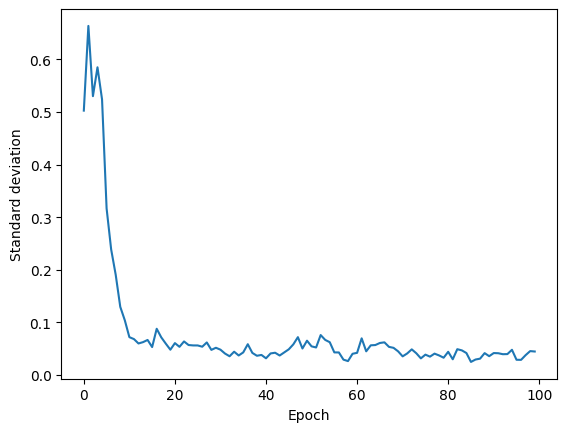

In [29]:
plt.plot(ppo_agent.training_results["std_action_0"])
plt.xlabel("Epoch")
plt.ylabel("Standard deviation")
plt.show()

In [30]:
ppo_agent.training_results["avg_reward"]

[0.32984375,
 0.44062500000000004,
 0.3925,
 0.36703125000000003,
 0.38328125,
 0.419375,
 0.50453125,
 0.555625,
 0.58859375,
 0.56796875,
 0.619375,
 0.6140625,
 0.6351562500000001,
 0.6157812500000001,
 0.6278125,
 0.63890625,
 0.581875,
 0.61671875,
 0.605,
 0.6109375,
 0.63859375,
 0.63953125,
 0.6343749999999999,
 0.6534374999999999,
 0.6271875,
 0.63546875,
 0.6375000000000001,
 0.6395312500000001,
 0.6443749999999999,
 0.641875,
 0.63796875,
 0.6284375,
 0.64953125,
 0.64796875,
 0.65078125,
 0.64546875,
 0.64828125,
 0.6284375,
 0.6460937499999999,
 0.6364062500000001,
 0.63109375,
 0.6325000000000001,
 0.64890625,
 0.655625,
 0.66359375,
 0.6553125,
 0.610625,
 0.6031250000000001,
 0.6470312500000001,
 0.62359375,
 0.6490625,
 0.635,
 0.6440625,
 0.6214062499999999,
 0.6453125000000001,
 0.65921875,
 0.6434375,
 0.6625000000000001,
 0.67140625,
 0.65734375,
 0.6671875,
 0.619375,
 0.6398437499999999,
 0.668125,
 0.66234375,
 0.6631250000000001,
 0.6585937500000001,
 0.6567187

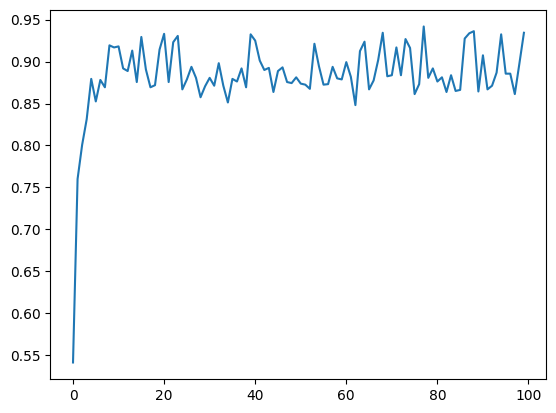

In [55]:
import matplotlib.pyplot as plt
plt.plot(np.mean(q_env.reward_history, axis=-1))

In [28]:
job.status

'completed'